In [ ]:
# Import the necessary libraries
import pyazr
import emcee

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from tqdm import tqdm
from natsort import natsorted
from brick.azr import AZR as brick

labels = ["Abramovich-A0244002",
          "Elwyn-F0012002",
          "Elwyn-F00112003",
          "Elwyn-F00112005",
          "Fasoli-D0135002",
          "Harrison-C1003002",
          "Ivanovich-A1014010",
          "McCray-A1410002",
          "McCray-A1410003",
          "Paneru",
          "Schenk-F0049002",
          "Spiger-A1094004",
          "Spiger-A1094007",
          "Tumino-O1221002"]

In [2]:
# Read the .h5 file
backend = emcee.backends.HDFBackend("results/samples.h5")

# Get number of samples
ns = backend.iteration

# Get the number of samples after burn in
nb  = ns - 10000
lnp = backend.get_log_prob(discard=nb)
ii  = np.where(np.median(lnp, axis=0)!=-np.inf)[0]

# Get only the first chain
samples = backend.get_chain(discard=nb, thin=1)[:, ii, :]
samples = samples.reshape((-1, samples.shape[-1]))

# Get the number of parameters
ndim = samples.shape[-1]

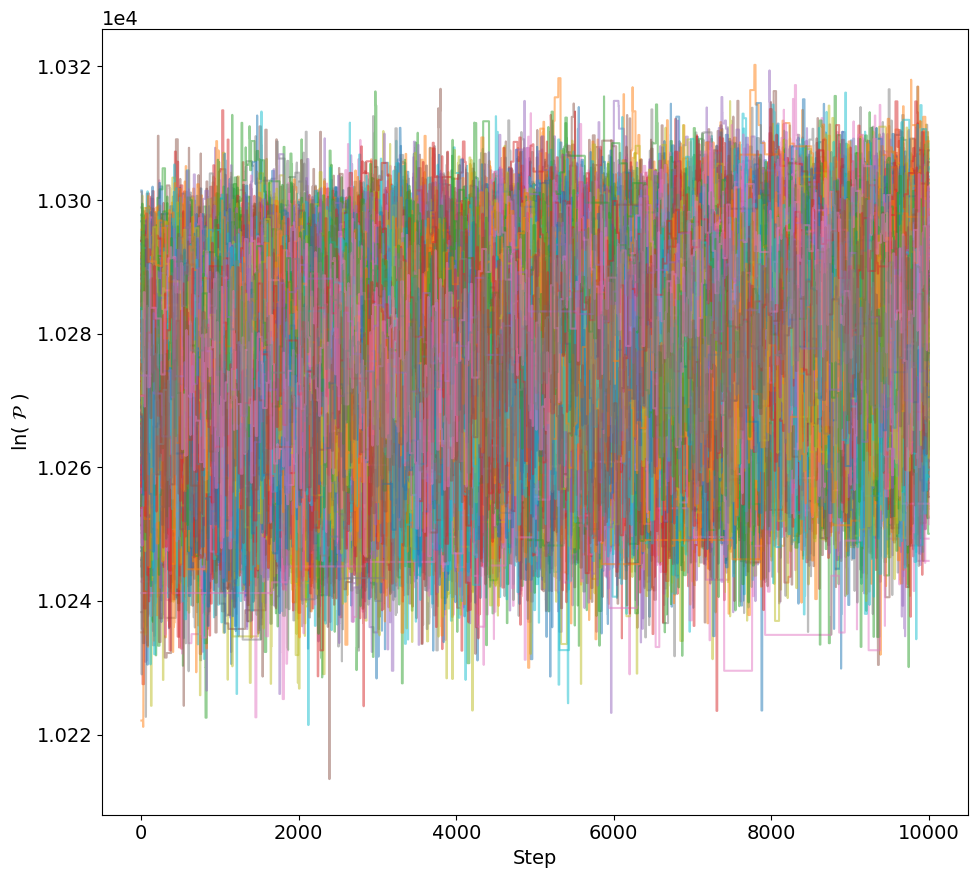

In [3]:
plt.figure( figsize=(10,9) )

plt.rcParams.update({'font.size': 14})

# Plot the posterior value
plt.plot( lnp[:, ii], alpha=0.5 )

plt.ylabel( r'ln( $\mathcal{P}$ )' )
plt.xlabel( "Step" )

# Scientific notation
plt.ticklabel_format( axis='y', style='sci', scilimits=(0,0) )

plt.tight_layout( )

plt.savefig( "results/lnp.png" )
plt.show( )

In [4]:
# Get the lables
brk = brick( "test3.azr" )
params_labels = brk.config.labels

In [5]:
# Write the parameters to file with first column the parameter name and the second the median value
with open( "results/parameters.txt", "w" ) as f:
    for i in range( ndim ):
        f.write( "{} {}\n".format( params_labels[i], np.median( samples[:,i] ) ) )

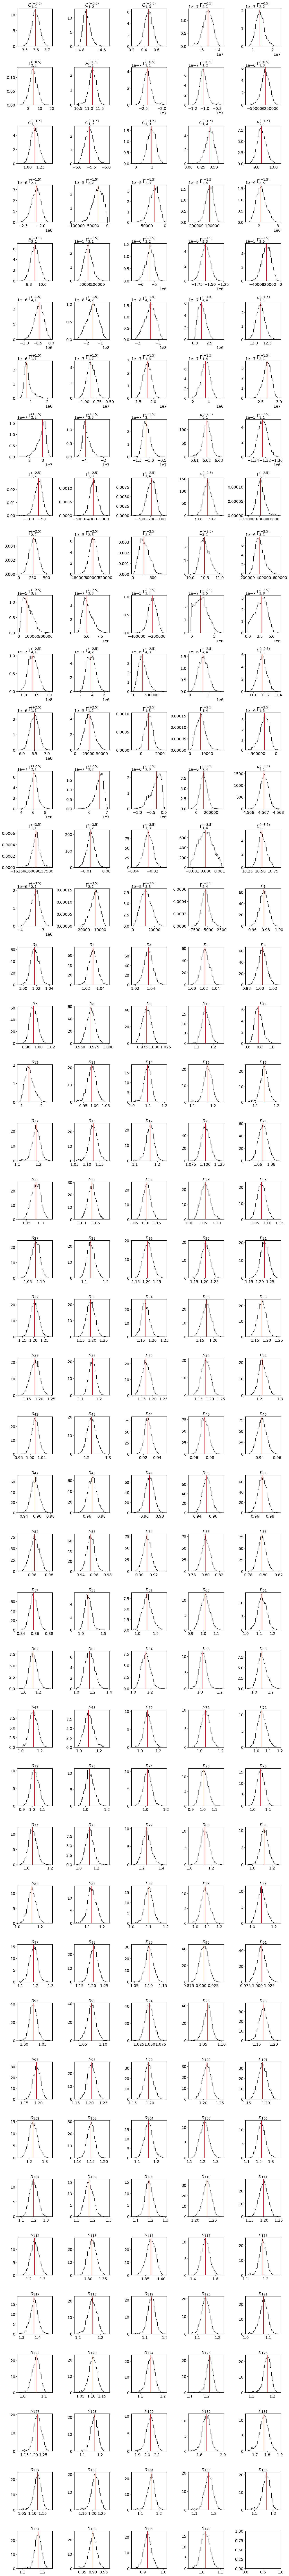

In [6]:
# Calculate grid size
ncols = 5
nrows = -(-ndim // ncols)  # Ceiling division

# Create the subplot grid
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i in range( ndim ):
    ax = axes[i]

    # Plot the histogram
    ax.hist( samples[:,i], bins=50, density=True, histtype='step', color='k' )

    # Plot the median value
    ax.axvline( np.median( samples[:,i] ), color='r' )

    ax.set_title( params_labels[i] )

# Adjust layout
fig.tight_layout()

plt.savefig( "results/parameters.png" )
plt.show( )

In [7]:
# Prepare pyazr to extrapolate the data
azr = pyazr.azure2( "test3.azr" )
segments = azr.nsegments

Calculating Lo-Matrix, Phases, and Penetrabilities...
Calculating Legendre Polynomials...
Calculating Coulomb Amplitudes...
Calculating External Capture Amplitudes...


In [8]:
# Get best median values for normalization
best = np.median( samples, axis=0 )
norms = best[ndim-segments:]

In [9]:
# Calculate the extrapolations
energies = azr.calculate_energies( samples[0] )
results = { "Segment {}".format( i+1 ): [] for i in range( len( energies ) ) }
for par in tqdm( samples[:1000] ):
    sample = azr.calculate_sfactor( par[:len(par)-len(energies)] )
    for i in range( len( sample ) ):
        results[ "Segment {}".format( i+1 ) ].append( sample[ i ] )

100%|██████████| 1000/1000 [03:25<00:00,  4.86it/s]


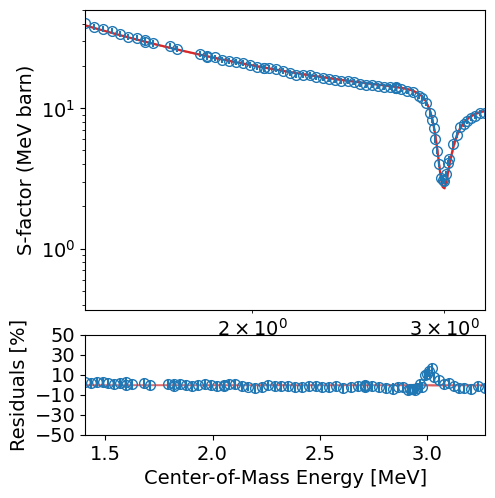

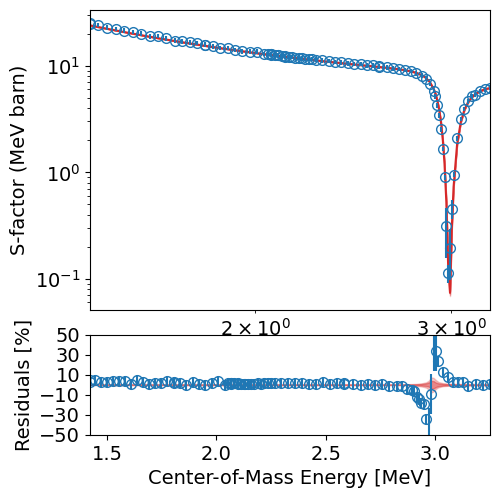

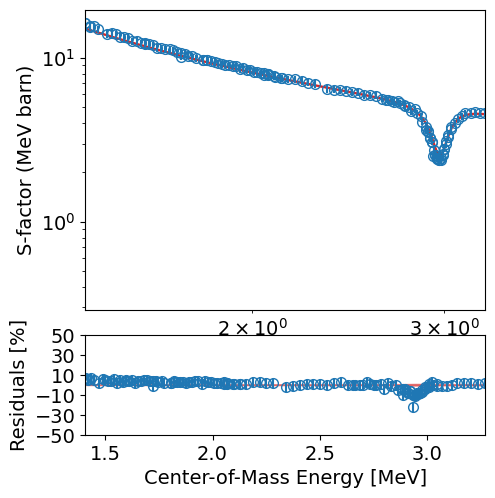

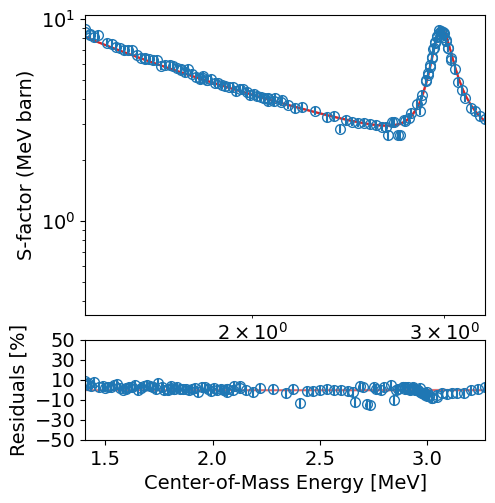

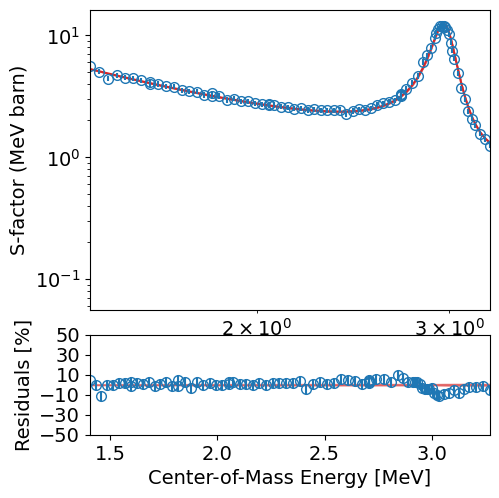

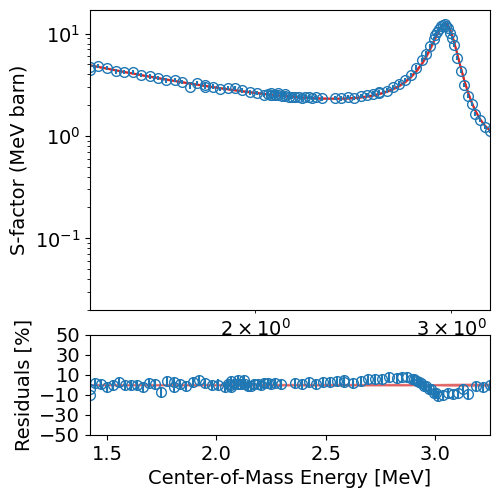

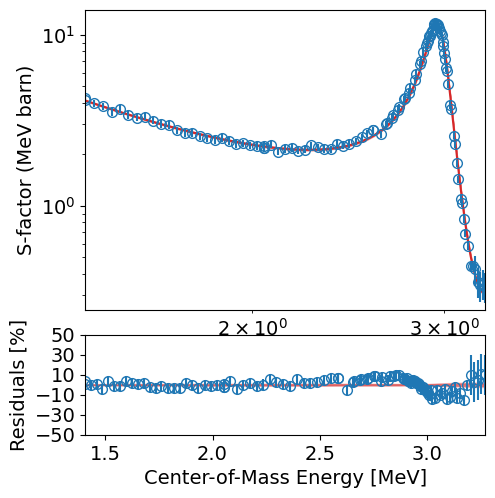

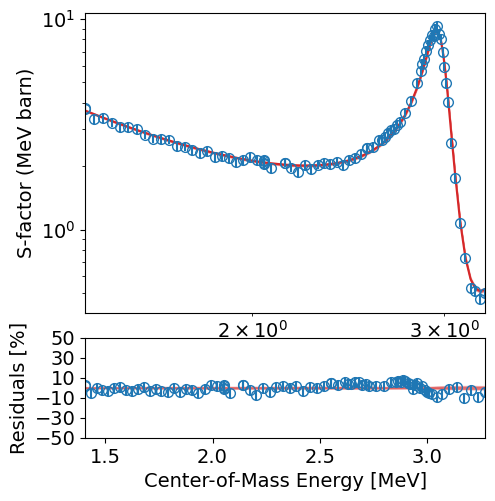

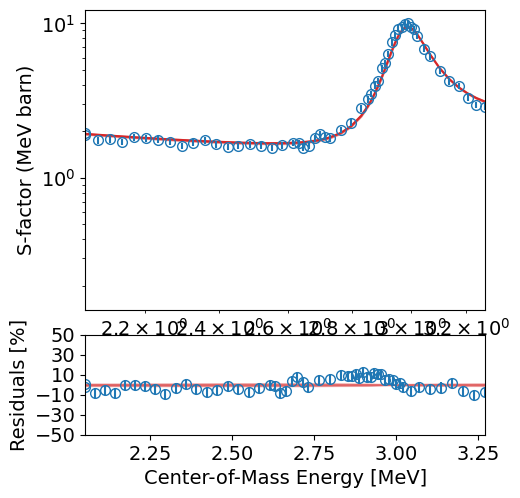

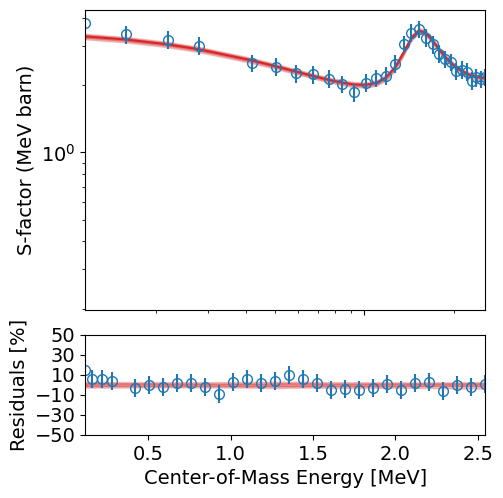

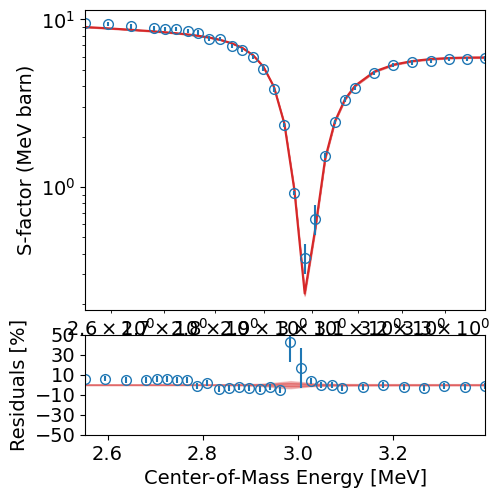

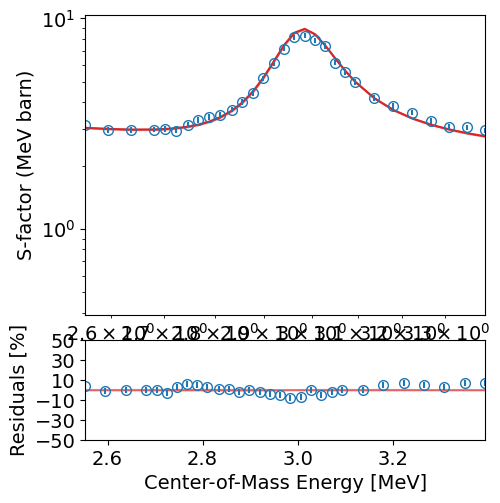

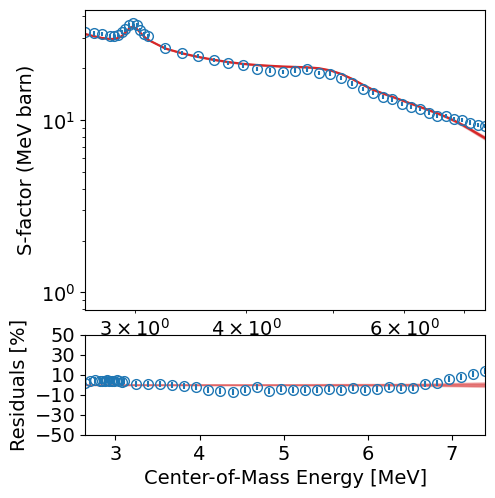

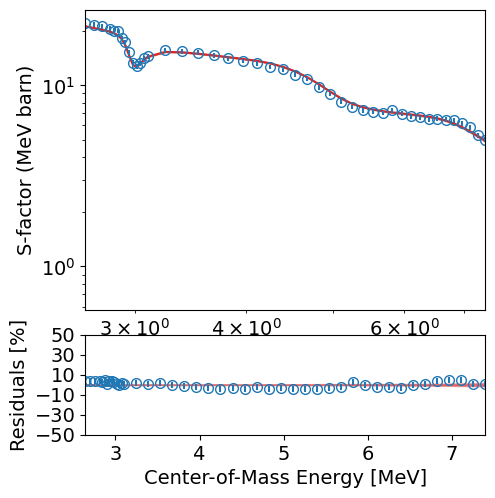

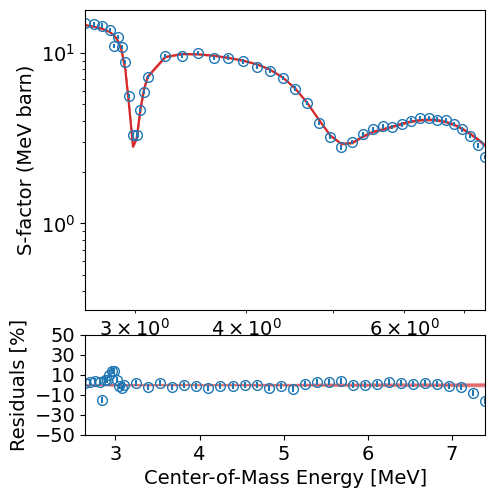

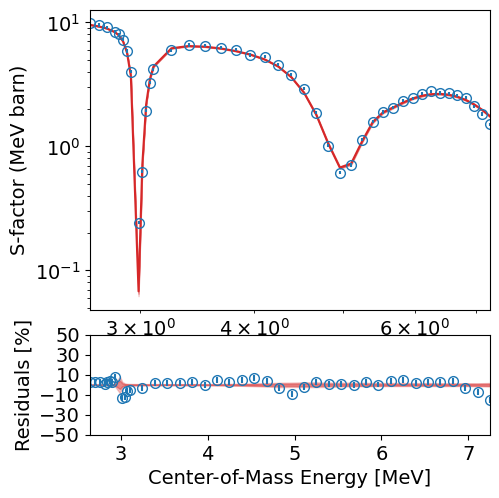

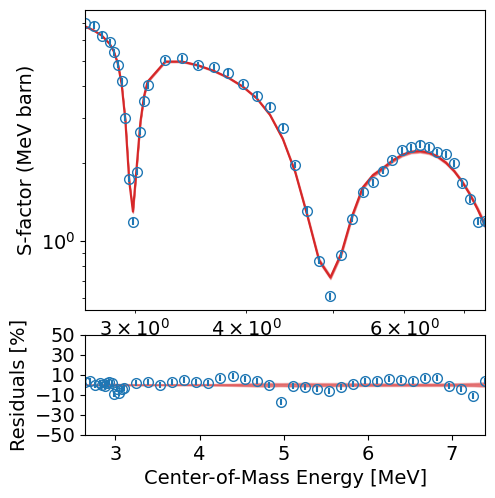

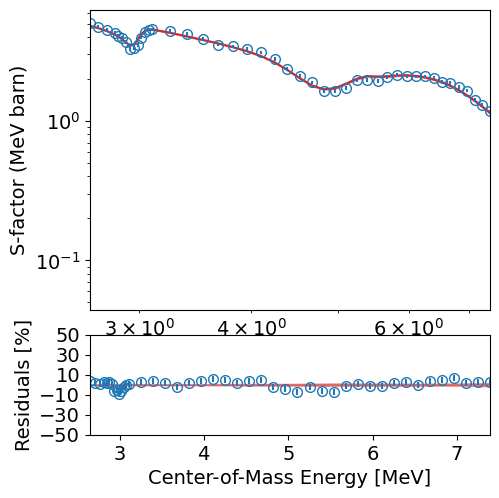

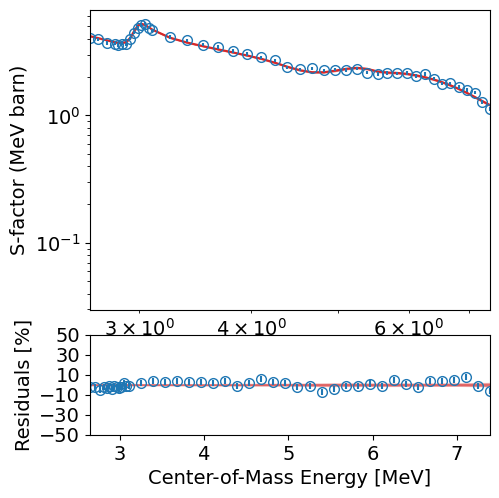

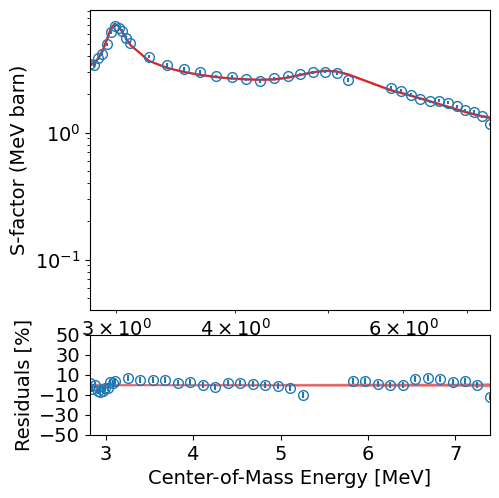

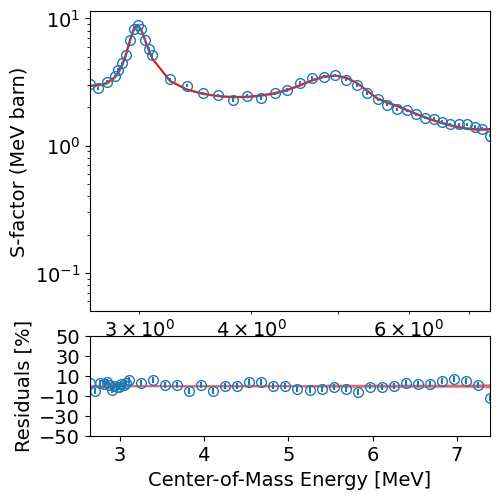

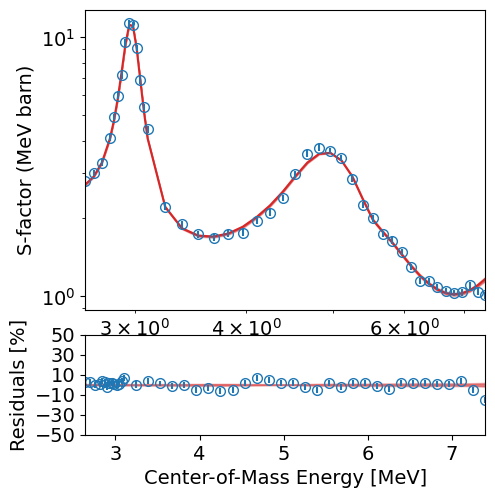

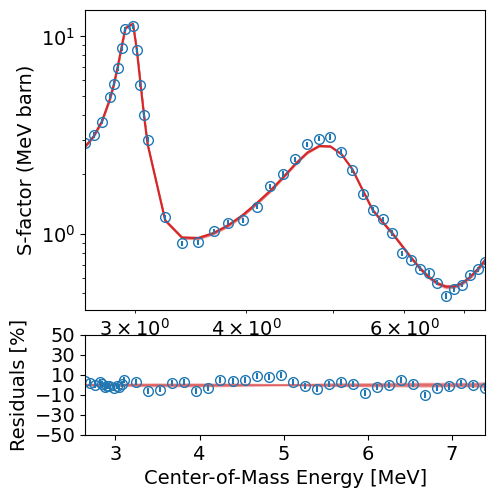

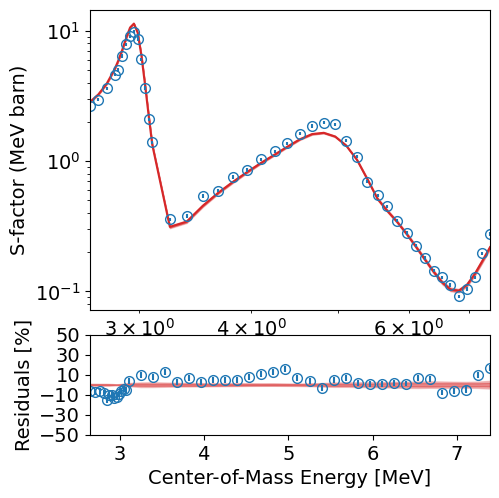

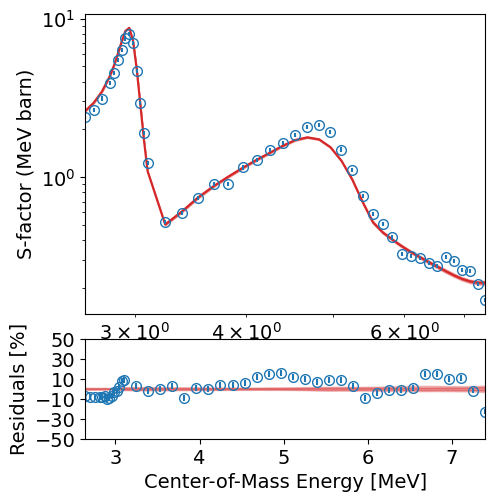

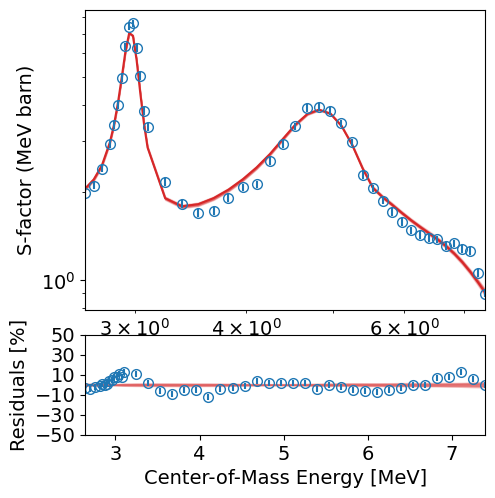

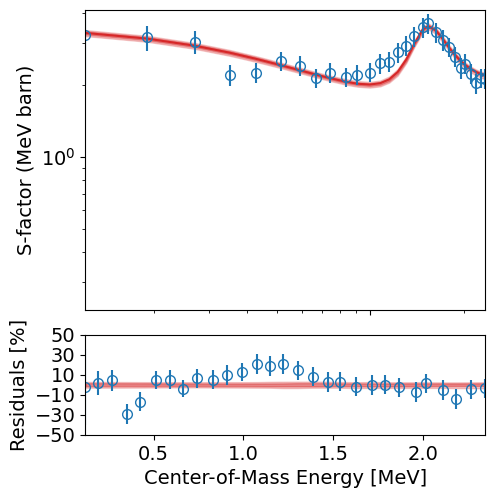

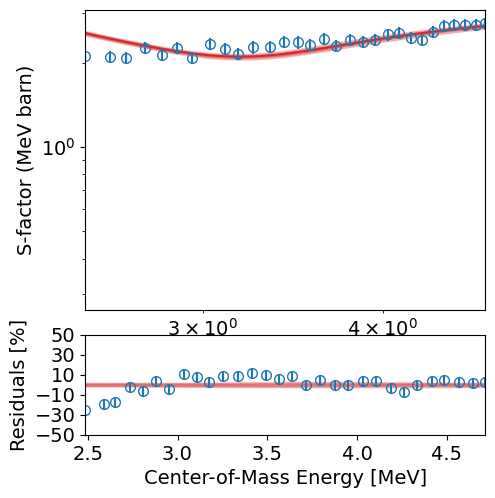

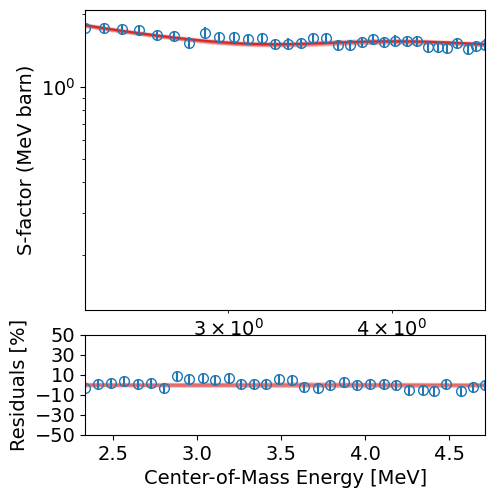

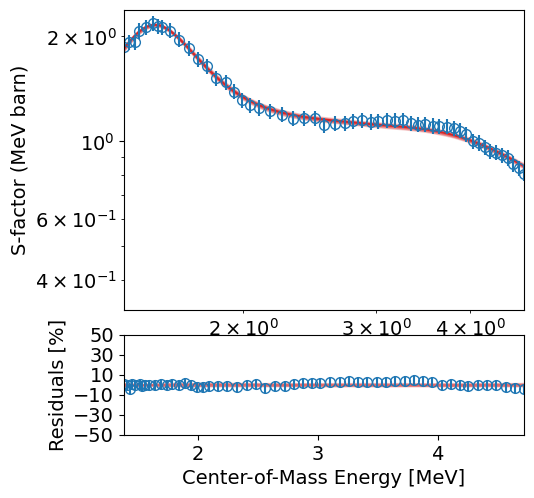

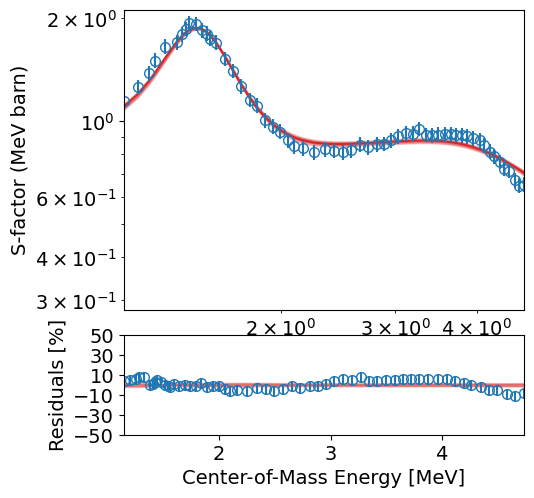

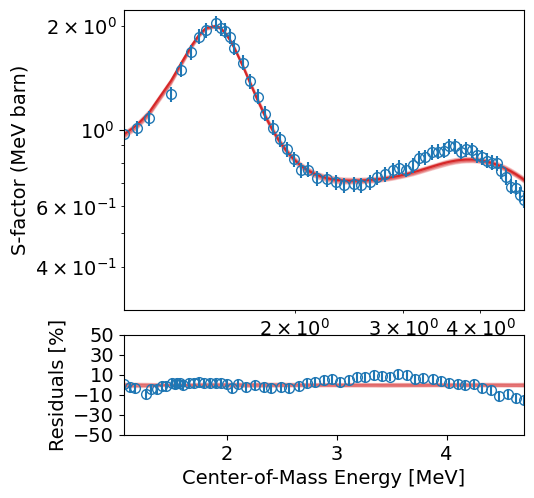

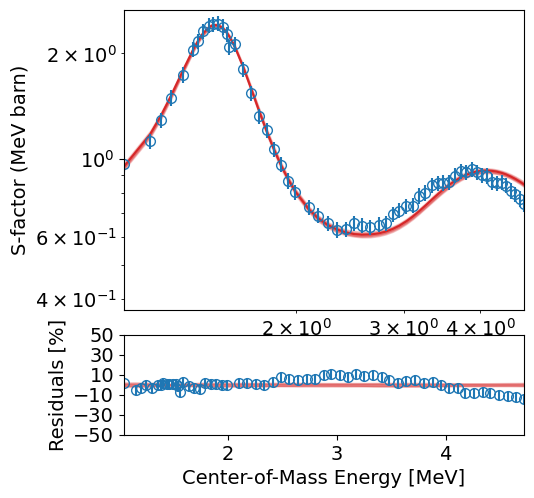

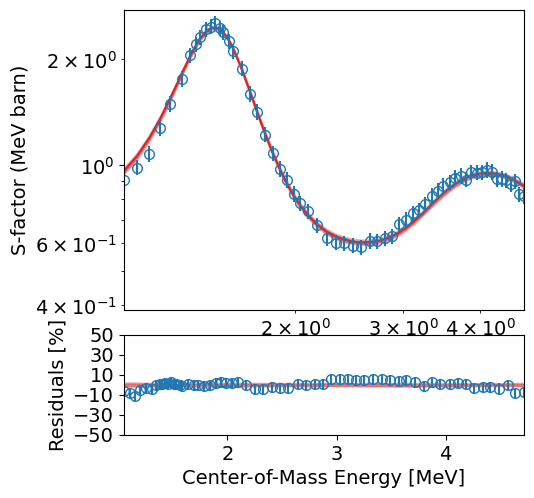

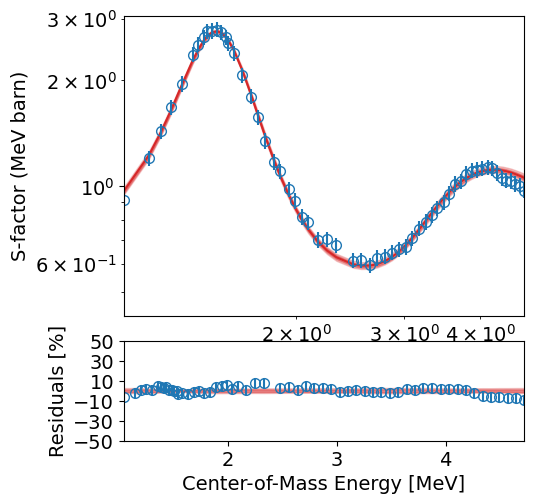

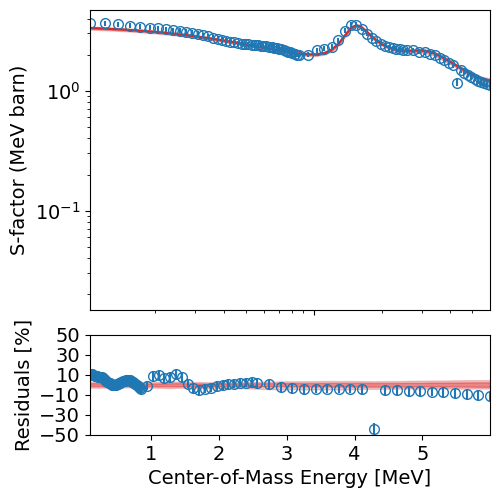

In [10]:
# Prepare the figures
for j, (segment, values) in enumerate(results.items()):

    # If less than 10 points, skip
    if len( energies[j] ) < 10:
        continue

    if( np.max( energies[j] ) == np.min( energies[j] ) ):
        continue

    mean = np.zeros( len( values[0] ) )
    sigma_1up, sigma_1low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_2up, sigma_2low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    sigma_3up, sigma_3low = np.zeros( len( values[0] ) ), np.zeros( len( values[0] ) )
    for i in range( len( values[0] ) ):
        mean[i] = np.percentile( [ v[i] for v in values ], 50 )
        sigma_1up[i] = np.percentile( [ v[i] for v in values ], 84 ) - mean[i]
        sigma_1low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 16 )
        sigma_2up[i] = np.percentile( [ v[i] for v in values ], 97.5 ) - mean[i]
        sigma_2low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 2.5 )
        sigma_3up[i] = np.percentile( [ v[i] for v in values ], 99.7 ) - mean[i]
        sigma_3low[i] = mean[i] - np.percentile( [ v[i] for v in values ], 0.3 )

    fig1 = plt.figure( figsize=(5,5) )
    ax1 = fig1.add_axes((.1,.35,.8,.6))
    ax1.set_ylabel( "S-factor (MeV barn)" )
    ax1.set_yscale( 'log' )
    ax1.set_xscale( 'log' )
    ax1.set_xticklabels([])

    #ax1.set_title( titles[j], y=0.05, x=0.05, fontsize=12, fontweight='bold', horizontalalignment='left' )
    #ax1.text( 0.5, 0.95, titles[j], horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=12, fontweight='bold' )

    ax1.plot( energies[j], mean, color="tab:red" )

    (line, _ , _) = ax1.errorbar( azr.energies[j], azr.sfactor[j] * norms[j], yerr=azr.sfactor_err[j] * norms[j], fmt="o", markersize=7 )
    line.set_markerfacecolor('none')

    ax1.fill_between( energies[j], mean-sigma_1low, mean+sigma_1up, alpha=0.40, color="tab:red" )
    ax1.fill_between( energies[j], mean-sigma_2low, mean+sigma_2up, alpha=0.25, color="tab:red" )
    #ax1.fill_between( energies[j], mean-sigma_3low, mean+sigma_3up, alpha=0.10, color="tab:red" )

    ax1.set_xlim( np.min( energies[j] ), np.max( energies[j] ) )

    # Remove x-axis label
    ax1.set_xticklabels([])

    #plt.legend( )

    ax2 = fig1.add_axes((.1,.1,.8,.2))

    idx = [] 
    for k in range( len( azr.energies[j] ) ):
        idx.append( np.argmin( np.abs( energies[j] - azr.energies[j][k] ) ) )
    percent = 100 * ( azr.sfactor[j] * norms[j] - mean[idx] ) / azr.sfactor[j]
    percent_err = 100 * ( azr.sfactor_err[j] / azr.sfactor[j] )
    max_percent = max( abs( percent + percent_err ) )
    (line, _ , _) = ax2.errorbar( azr.energies[j], percent, yerr=percent_err, fmt="o", markersize=7 )
    line.set_markerfacecolor('none')

    ax2.fill_between( energies[j], -100 * sigma_1low / mean, 100 * sigma_1up / mean, color="tab:red", alpha=0.40 )
    ax2.fill_between( energies[j], -100 * sigma_2low / mean, 100 * sigma_2up / mean, color="tab:red", alpha=0.25, label='2 sigma' )
    #ax2.fill_between( energies[j], -100 * sigma_3low / mean, 100 * sigma_3up / mean, color="tab:red", alpha=0.10, label='3 sigma' )
    
    ax2.set_xlabel( "Center-of-Mass Energy [MeV]" )
    ax2.set_ylabel( "Residuals [%]" )

    ax2.set_xlim( np.min( energies[j] ), np.max( energies[j] ) )

    ax2.set_yticks( [-50, -30, -10, 10, 30, 50] )

    ax2.set_ylim( -50, 50 )
    
    plt.savefig( "results/plots/{}.png".format( segment ) )
    plt.show( )

In [ ]:
# Calculate correlation matrix for data
correlation = np.corrcoef( samples.T )

# Get only the lower triangular part
corr = np.tril( correlation, k=-1 )
mask = np.triu( correlation )

# Plot the correlations
fig = plt.figure( figsize=(10,12) )

cmap = sns.diverging_palette(220, 20, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.collections[0].set_clim(-1,1)

#ax.set_xticklabels(params_labels, rotation=90)
#ax.set_yticklabels(params_labels, rotation=0)

plt.show( )